In [13]:
import pandas as pd
import signac
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy.polynomial.polynomial as poly

PA_DEGREE = 6

def mean_squared_error(y_obs, y_pre):
    
    N = len(y_obs)
    # Check same number of samples
    assert N == len(y_pre)
    
    return np.sum((y_obs - y_pre)**2)/N


def make_plots(job_list, path):
    project = signac.get_project(path)
    jobs = project.find_jobs(doc_filter={"cure_percent":{"$gte":80}})
    
    exp_data = np.load("../exp_data.npz")
    doc, pa, sa, ta = exp_data["arr_0"], exp_data["arr_1"], exp_data["arr_2"], exp_data["arr_3"]
    
    coefs_sa = poly.polyfit(doc, sa, 6)
    ffit_sa = poly.Polynomial(coefs_sa)
    coefs_pa = poly.polyfit(doc, pa, PA_DEGREE)
    ffit_pa = poly.Polynomial(coefs_pa)
    
    for job in jobs:
        if job._id in job_list:
            try:
                df = pd.read_csv(job.fn("_test_species.log"), delimiter="\t")
            except(FileNotFoundError):
                continue
            print("-----------")
            print(job._id)
            print("R2 FO", job.doc.SAFO_model_R2)
            print("Ea", job.sp.activation_energy)
            print("deltaT", job.sp.deltaT)
            print("sec_bond_weight", job.sp.sec_bond_weight)
            print("% bonds per step" ,job.sp.percent_bonds_per_step)
            print("bond period", job.sp.bond_period)


            cure_fractions = np.asarray(df["#doc"])
            primaryA_cnts = np.asarray(df["primaryA"]) # 0
            secondaryA_cnts = np.asarray(df["secondaryA"]) # 1
            ternaryA_cnts = np.asarray(df["ternaryA"]) # 2 
            quarternaryA_cnts = np.asarray(df["quarternaryA"]) # 3
            fivernaryA_cnts = np.asarray(df["fivernaryA"]) # 4
            scale_factor = primaryA_cnts[0]*2
            primaryA_cnts=primaryA_cnts/scale_factor # 0
            secondaryA_cnts=secondaryA_cnts/scale_factor # 1
            ternaryA_cnts=ternaryA_cnts/scale_factor # 2
            quarternaryA_cnts=quarternaryA_cnts/scale_factor # 3
            fivernaryA_cnts=fivernaryA_cnts/scale_factor # 4

            P_high = primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts
            P_low =  primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts*0

            S_high = secondaryA_cnts + ternaryA_cnts*2 + quarternaryA_cnts
            S_low =  secondaryA_cnts + ternaryA_cnts*0 +quarternaryA_cnts

            T_high = ternaryA_cnts+quarternaryA_cnts+fivernaryA_cnts*2
            T_low = quarternaryA_cnts+fivernaryA_cnts*2

            MSE_P = mean_squared_error(ffit_pa(cure_fractions), P_low)
            MSE_S = mean_squared_error(ffit_sa(cure_fractions), S_low)
            mean_MSE = (MSE_P + MSE_S)/2
            mean_MSEs.append((mean_MSE, job._id))

            print("MSE Primary: ", MSE_P)
            print("MSE Secondary: ", MSE_S)
            print("Mean MSE: ", round(mean_MSE,4))

            plt.figure(dpi=300)

            plt.plot(cure_fractions, P_low, color='#1f77b4', linestyle="--", label="low", marker=".", linewidth=0)
            plt.plot(cure_fractions, S_low, color="#ff7f0e", linestyle="--", marker=".", linewidth=0)


            plt.plot(doc, ffit_pa(doc), color='#1f77b4', linestyle='-', label="exp",)
            plt.plot(doc, ffit_sa(doc), color='#ff7f0e', linestyle='-',)


            primary = mpatches.Patch(color='#1f77b4', label='Primary Amine')
            seconday = mpatches.Patch(color='#ff7f0e', label='Secondary Amine')
            exp = mlines.Line2D([], [], color='grey', linestyle='-', label="Experiment Ref. XX")
            low = mlines.Line2D([], [], color='grey', linestyle='--', label="Simulation")
            
            



            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = OrderedDict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), prop={'size': 15})
            plt.legend(handles=[primary,seconday,exp, low])


            plt.title(str(job._id)+ " RXN Fit:"+ str(round(job.doc.SAFO_model_R2,4)))
            plt.xlabel("Degree of Cure", size=15)
            plt.ylabel("Normalized Concentration", size=15)
            plt.xlim(0,1)
            plt.show()
            
def get_R2s_and_mean_MSEs(path):
    project = signac.get_project(path)
    jobs = project.find_jobs(filter={"bond": True}, doc_filter={"cure_percent":{"$gte":80}})

    exp_data = np.load("../exp_data.npz")
    doc, pa, sa, ta = exp_data["arr_0"], exp_data["arr_1"], exp_data["arr_2"], exp_data["arr_3"]

    coefs_sa = poly.polyfit(doc, sa, 6)
    ffit_sa = poly.Polynomial(coefs_sa)
    coefs_pa = poly.polyfit(doc, pa, PA_DEGREE)
    ffit_pa = poly.Polynomial(coefs_pa)


    jobs = project.find_jobs(doc_filter={"cure_percent":{"$gte":80}})
    R2s = []
    mean_MSEs = []
    for job in jobs:
        try:
            if job.doc.SAFO_model_R2 is not None:
                df = pd.read_csv(job.fn("_test_species.log"), delimiter="\t")
                R2s.append((job.doc.SAFO_model_R2, job._id))

                cure_fractions = np.asarray(df["#doc"])
                # first we check if there are enough data points
                # we also want to check we have some data points before we reach 50% DOC
                if len(cure_fractions) > 5 and (np.count_nonzero(cure_fractions < .5)) > 2:
                    #print(np.count_nonzero(cure_fractions < .5))
                    # two points less than 50% not zero 


                    primaryA_cnts = np.asarray(df["primaryA"]) # 0
                    secondaryA_cnts = np.asarray(df["secondaryA"]) # 1
                    ternaryA_cnts = np.asarray(df["ternaryA"]) # 2 
                    quarternaryA_cnts = np.asarray(df["quarternaryA"]) # 3
                    fivernaryA_cnts = np.asarray(df["fivernaryA"]) # 4
                    scale_factor = primaryA_cnts[0]*2
                    primaryA_cnts=primaryA_cnts/scale_factor # 0
                    secondaryA_cnts=secondaryA_cnts/scale_factor # 1
                    ternaryA_cnts=ternaryA_cnts/scale_factor # 2
                    quarternaryA_cnts=quarternaryA_cnts/scale_factor # 3
                    fivernaryA_cnts=fivernaryA_cnts/scale_factor # 4

                    P_low =  primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts*0
                    S_low =  secondaryA_cnts + ternaryA_cnts*0 +quarternaryA_cnts

                    MSE_P = mean_squared_error(ffit_pa(cure_fractions), P_low)
                    MSE_S = mean_squared_error(ffit_sa(cure_fractions), S_low)
                    mean_MSE = (MSE_P + MSE_S)/2

                    mean_MSEs.append((MSE_P, job._id))
        except(AttributeError, FileNotFoundError):
            continue
    return R2s, mean_MSEs 

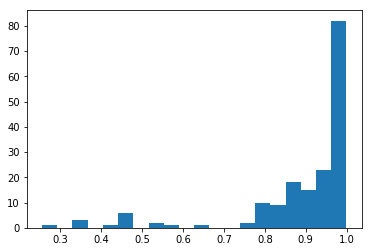

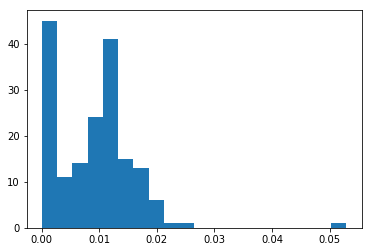

['515f81e4a30ffa2d72d9670be53a2291', 'd0f97714f57b69d2bc4bc1a341b449aa', '6d419f156c4492c96c0dbc3890ad0185', '4a92afd1984a1659b8f5bf60aea0ec2b', '80abb77ab7250f4a1ee66572cdd5dc1c', 'a6e313af6c849f33966ba9eeaefeed51', 'b211093c9abdce551e001fb2bd9a6ada', '7455fd919913e3b7d56a1353c5188366', 'd40f3526881a45c4228b7b468bfddce5', 'a15525ec74d0163a900bb585e456a20f', '3e50db02573004e93758375758939a34', '7108dc186b64e0e6a3766d7760ee265b', 'fcbfa0453c9a7994b516e148d8e746bd', 'aab88e9c89c6a8c69ceb32e886c01ec7', 'd46c910f0d39529bb1731891f573dfe4', 'd4045ce812837a2180533a21315391a8', '924b1ad6e21e0b9314710843eca2325e', '567ecd7d00a97e3e2a4dffa2b8ede7e9', '5bdad5ad337a5be395322747bf020caa', '2a8d841ec7cb7fd4dbbbfe005ec72fe4']
['aab88e9c89c6a8c69ceb32e886c01ec7', 'fcbfa0453c9a7994b516e148d8e746bd', '515f81e4a30ffa2d72d9670be53a2291', 'd0f97714f57b69d2bc4bc1a341b449aa', '4a92afd1984a1659b8f5bf60aea0ec2b', '6d419f156c4492c96c0dbc3890ad0185', '80abb77ab7250f4a1ee66572cdd5dc1c']
-----------
4a92afd1984a16

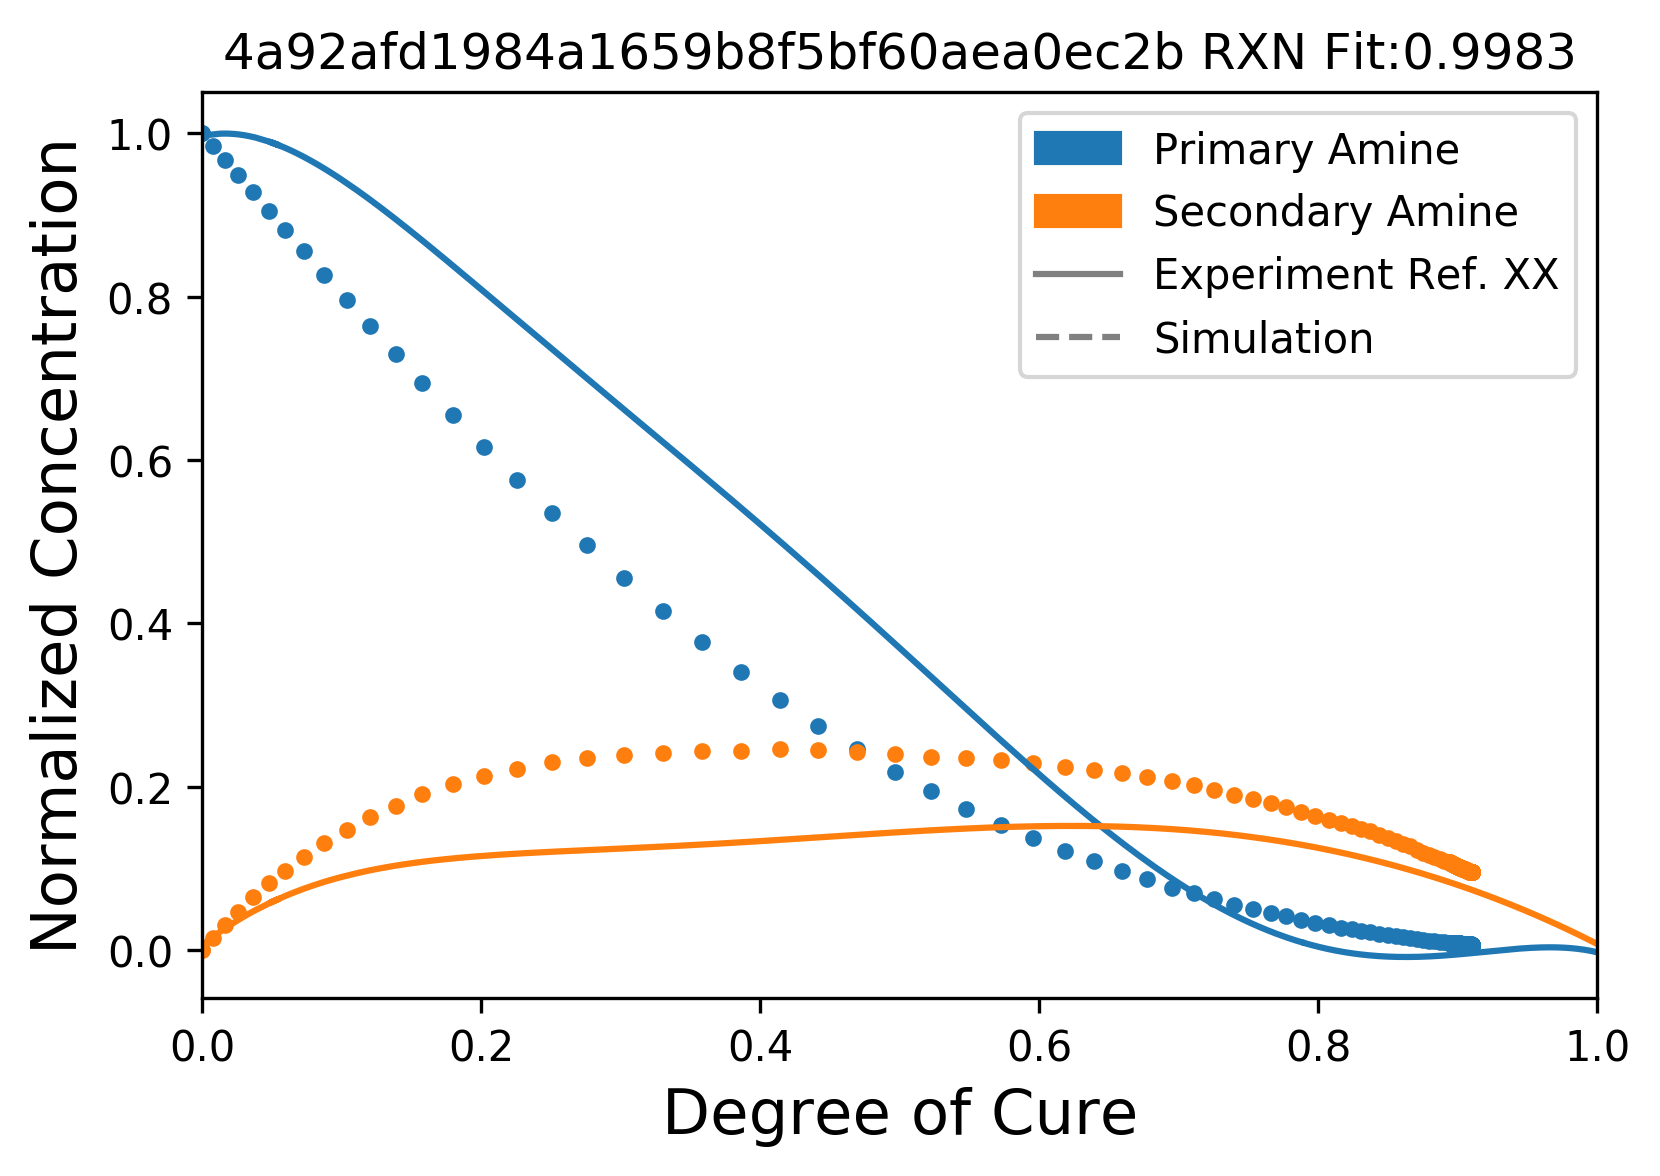

-----------
80abb77ab7250f4a1ee66572cdd5dc1c
R2 FO 0.9993404623176265
Ea 2.5
deltaT 5e-05
sec_bond_weight 1.2
% bonds per step 0.1
bond period 100
MSE Primary:  0.000343666287515196
MSE Secondary:  0.0009447711813391892
Mean MSE:  0.0006


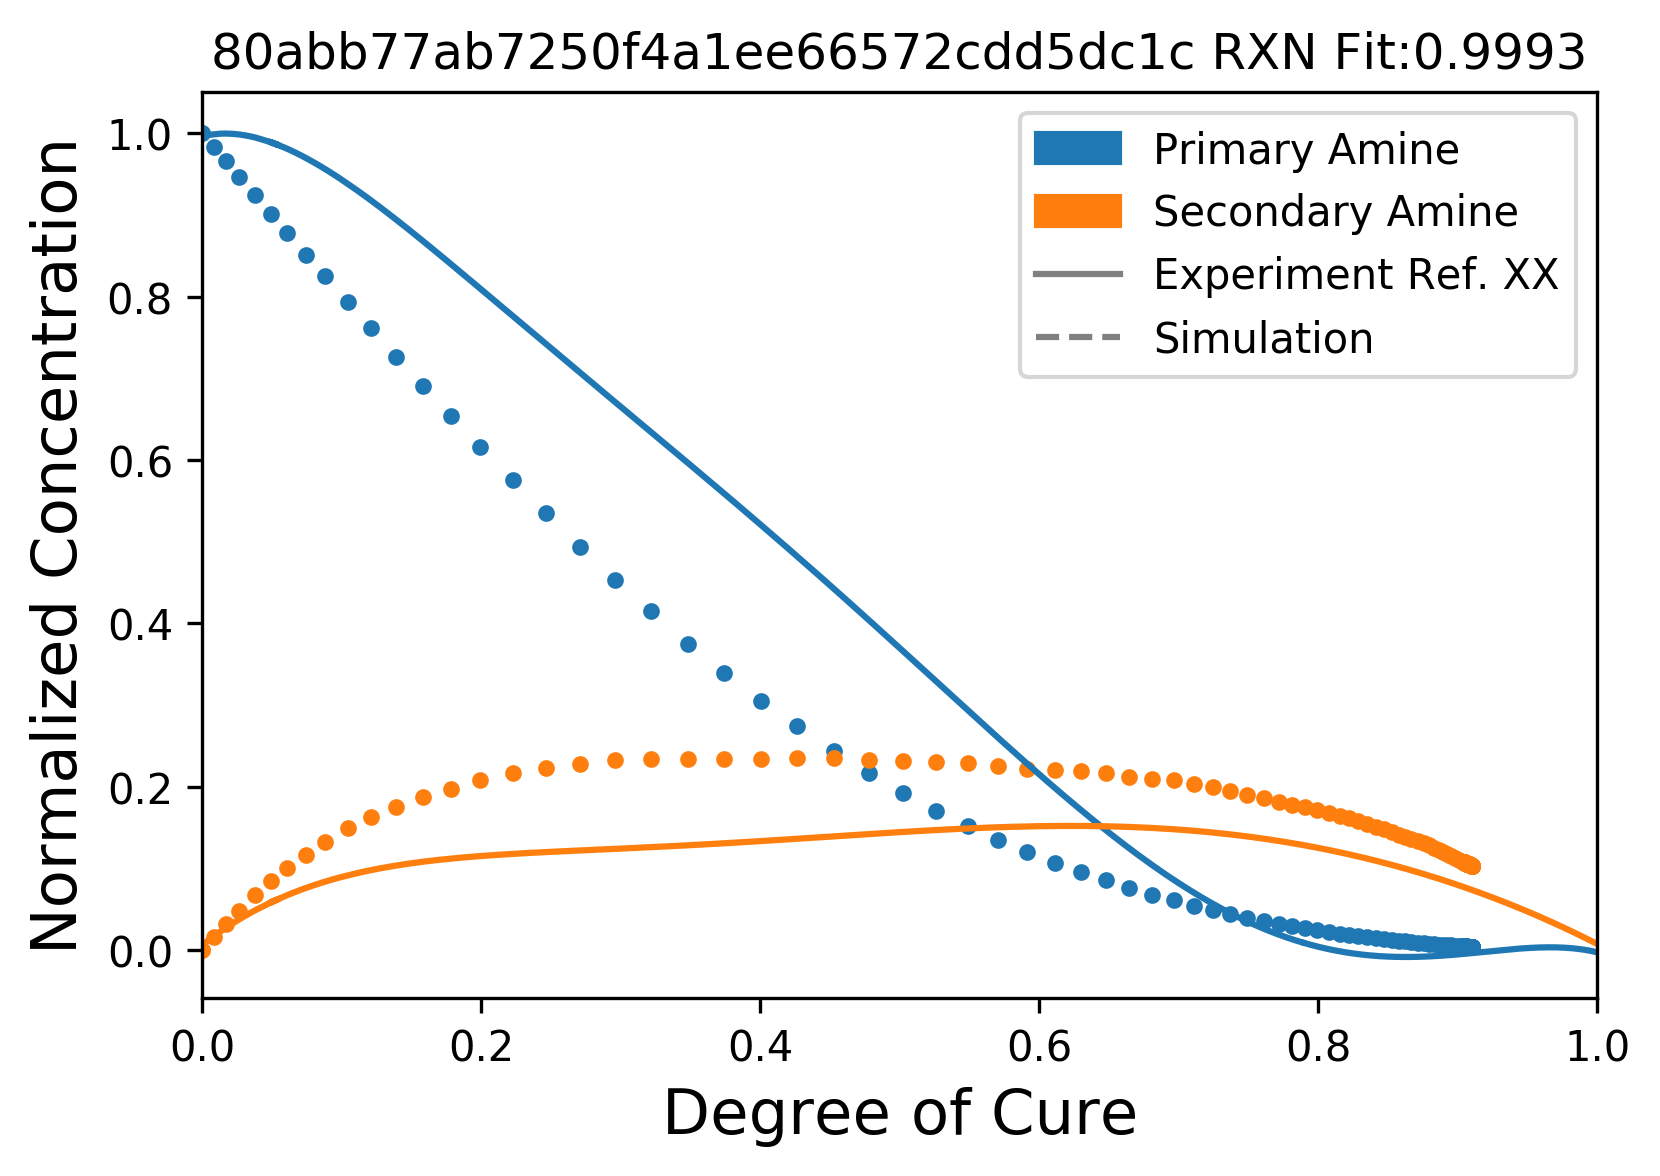

-----------
fcbfa0453c9a7994b516e148d8e746bd
R2 FO 0.9905331744231122
Ea 2.5
deltaT 5e-05
sec_bond_weight 1.2
% bonds per step 1.0
bond period 100
MSE Primary:  9.476251307174057e-05
MSE Secondary:  0.0006753164403098093
Mean MSE:  0.0004


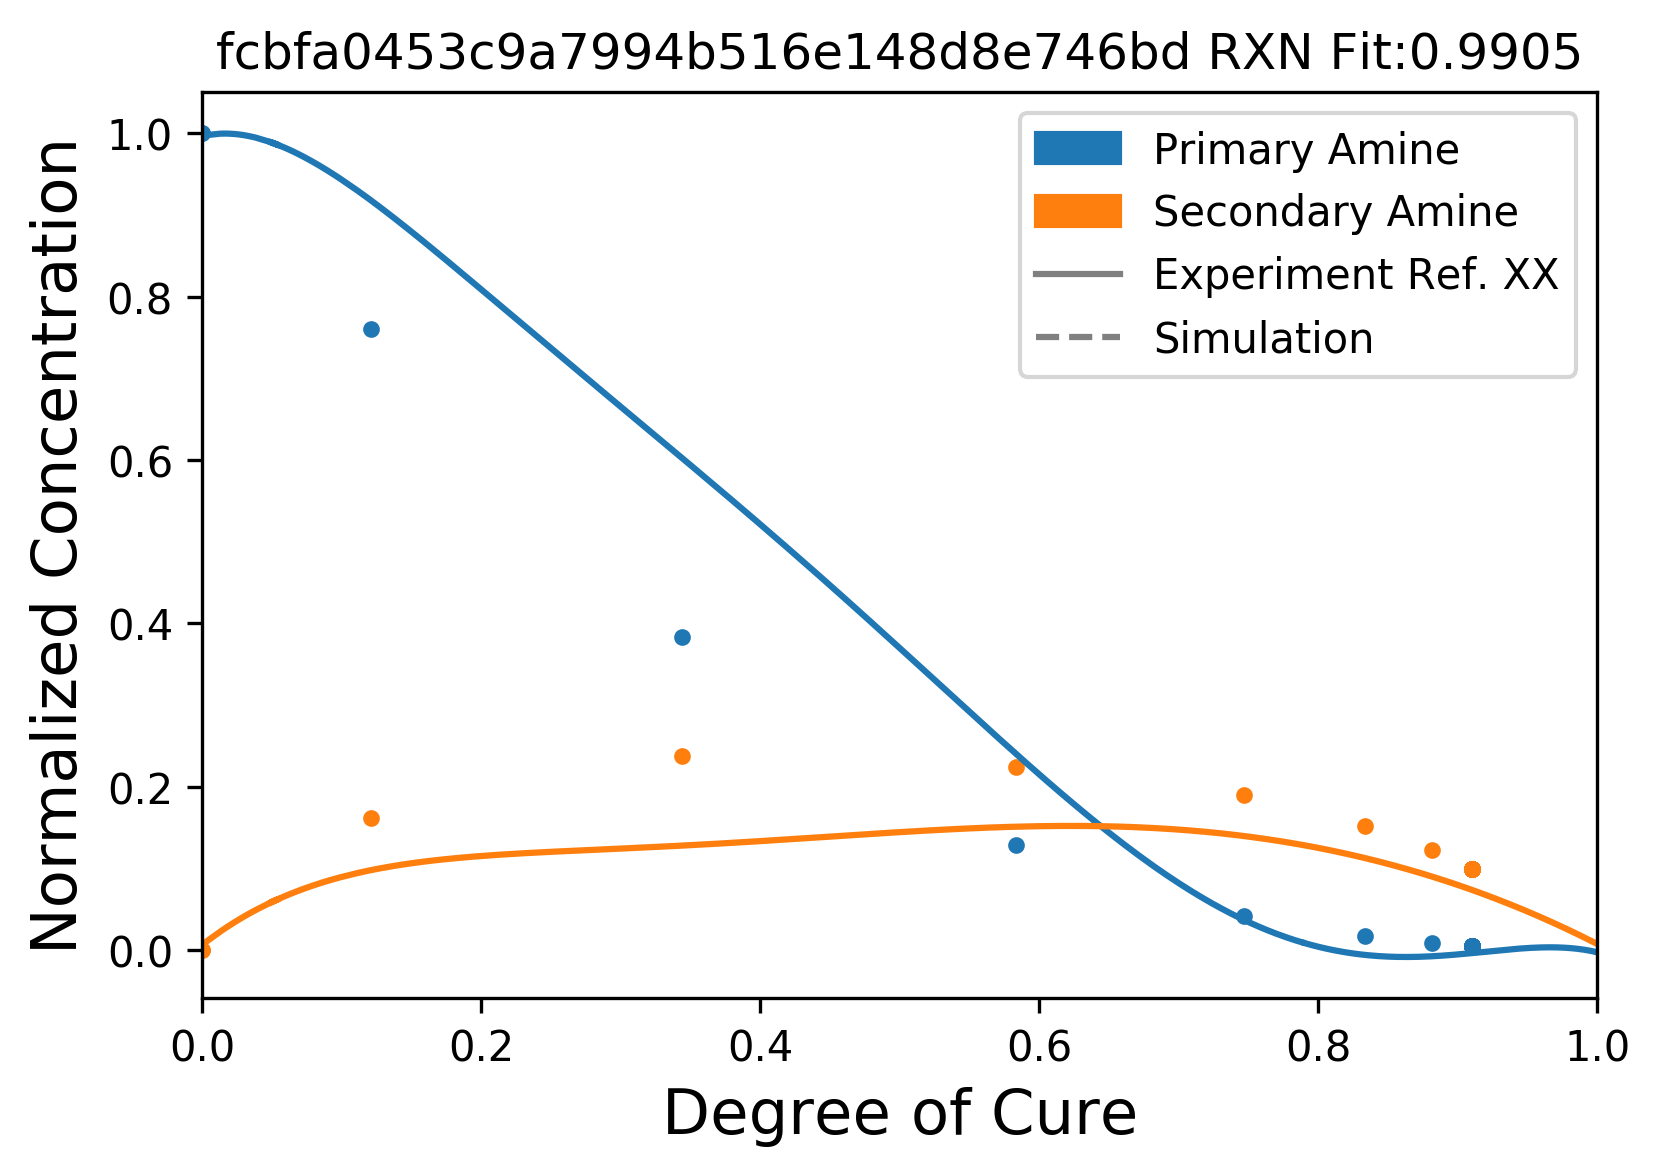

-----------
515f81e4a30ffa2d72d9670be53a2291
R2 FO 0.9817792352507538
Ea 3.0
deltaT 5e-05
sec_bond_weight 1.0
% bonds per step 0.01
bond period 10
MSE Primary:  0.00044074064879258466
MSE Secondary:  0.0006962779072838033
Mean MSE:  0.0006


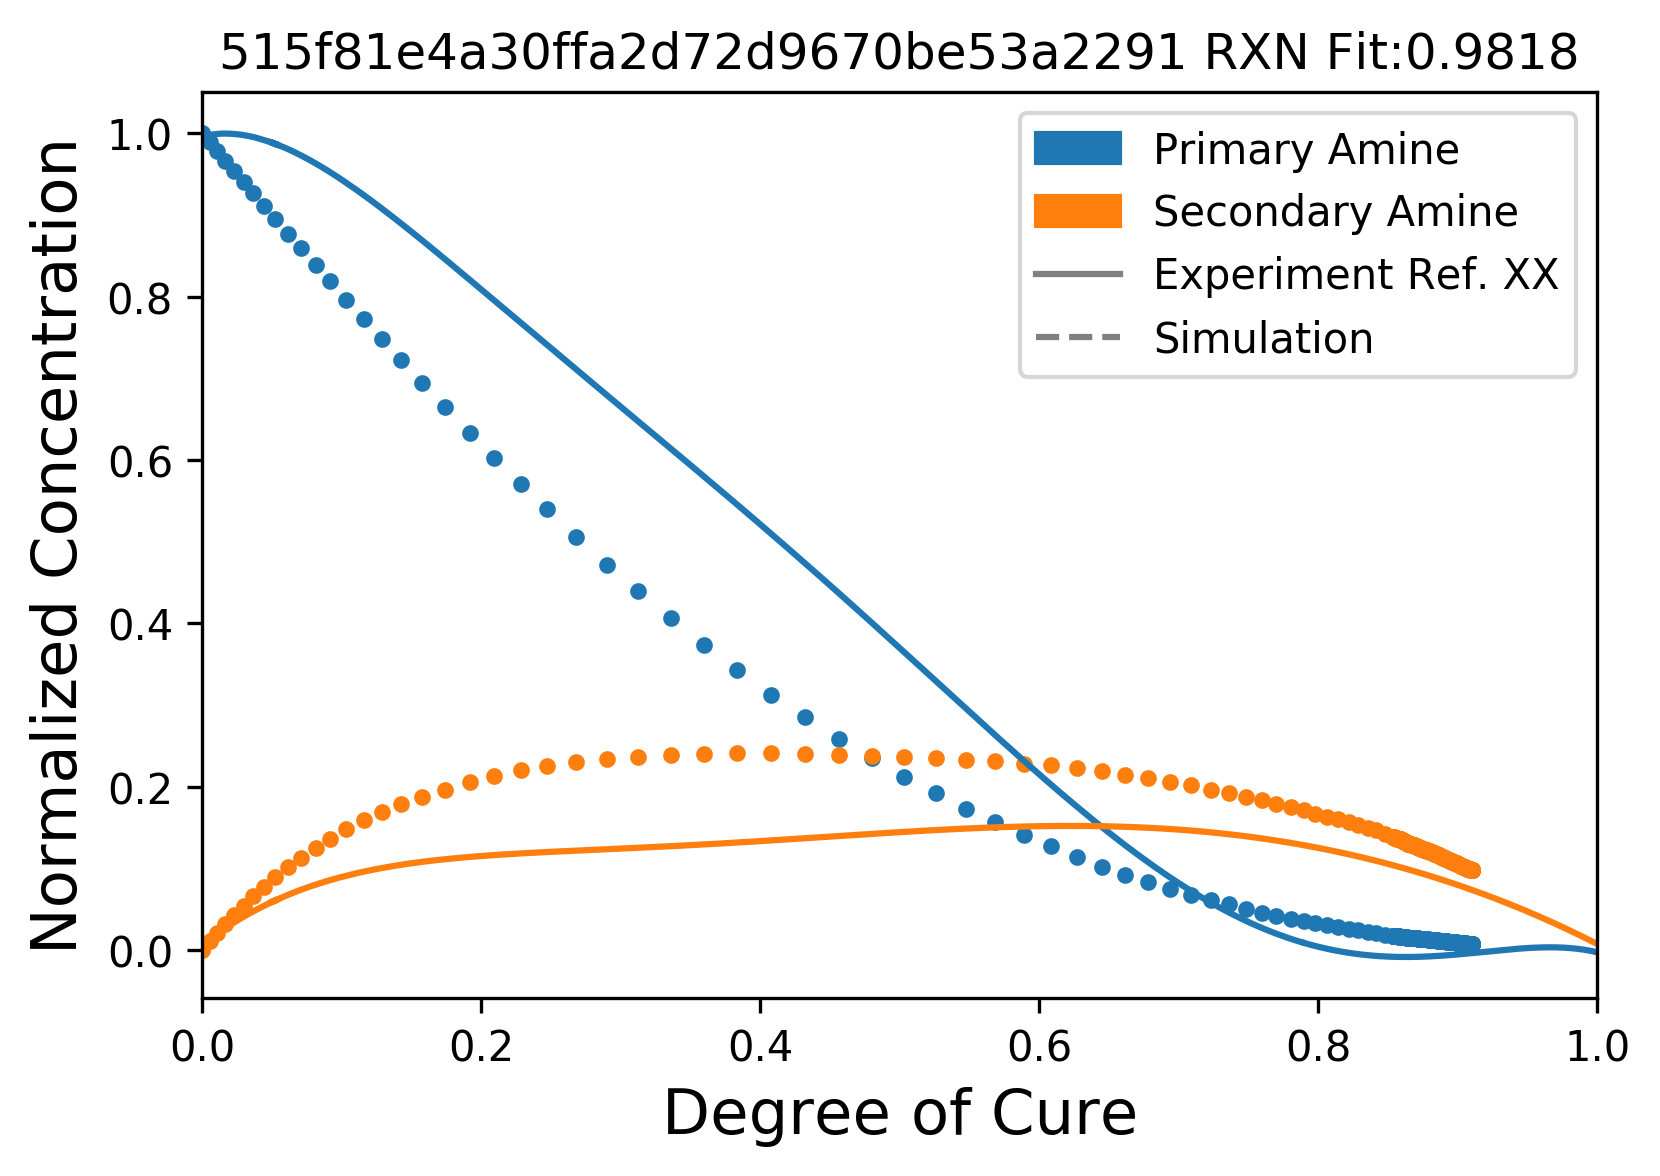

-----------
d0f97714f57b69d2bc4bc1a341b449aa
R2 FO 0.9821218224786382
Ea 5.5
deltaT 5e-05
sec_bond_weight 1.8
% bonds per step 0.1
bond period 10
MSE Primary:  0.0004100677757988371
MSE Secondary:  0.0027842968496807987
Mean MSE:  0.0016


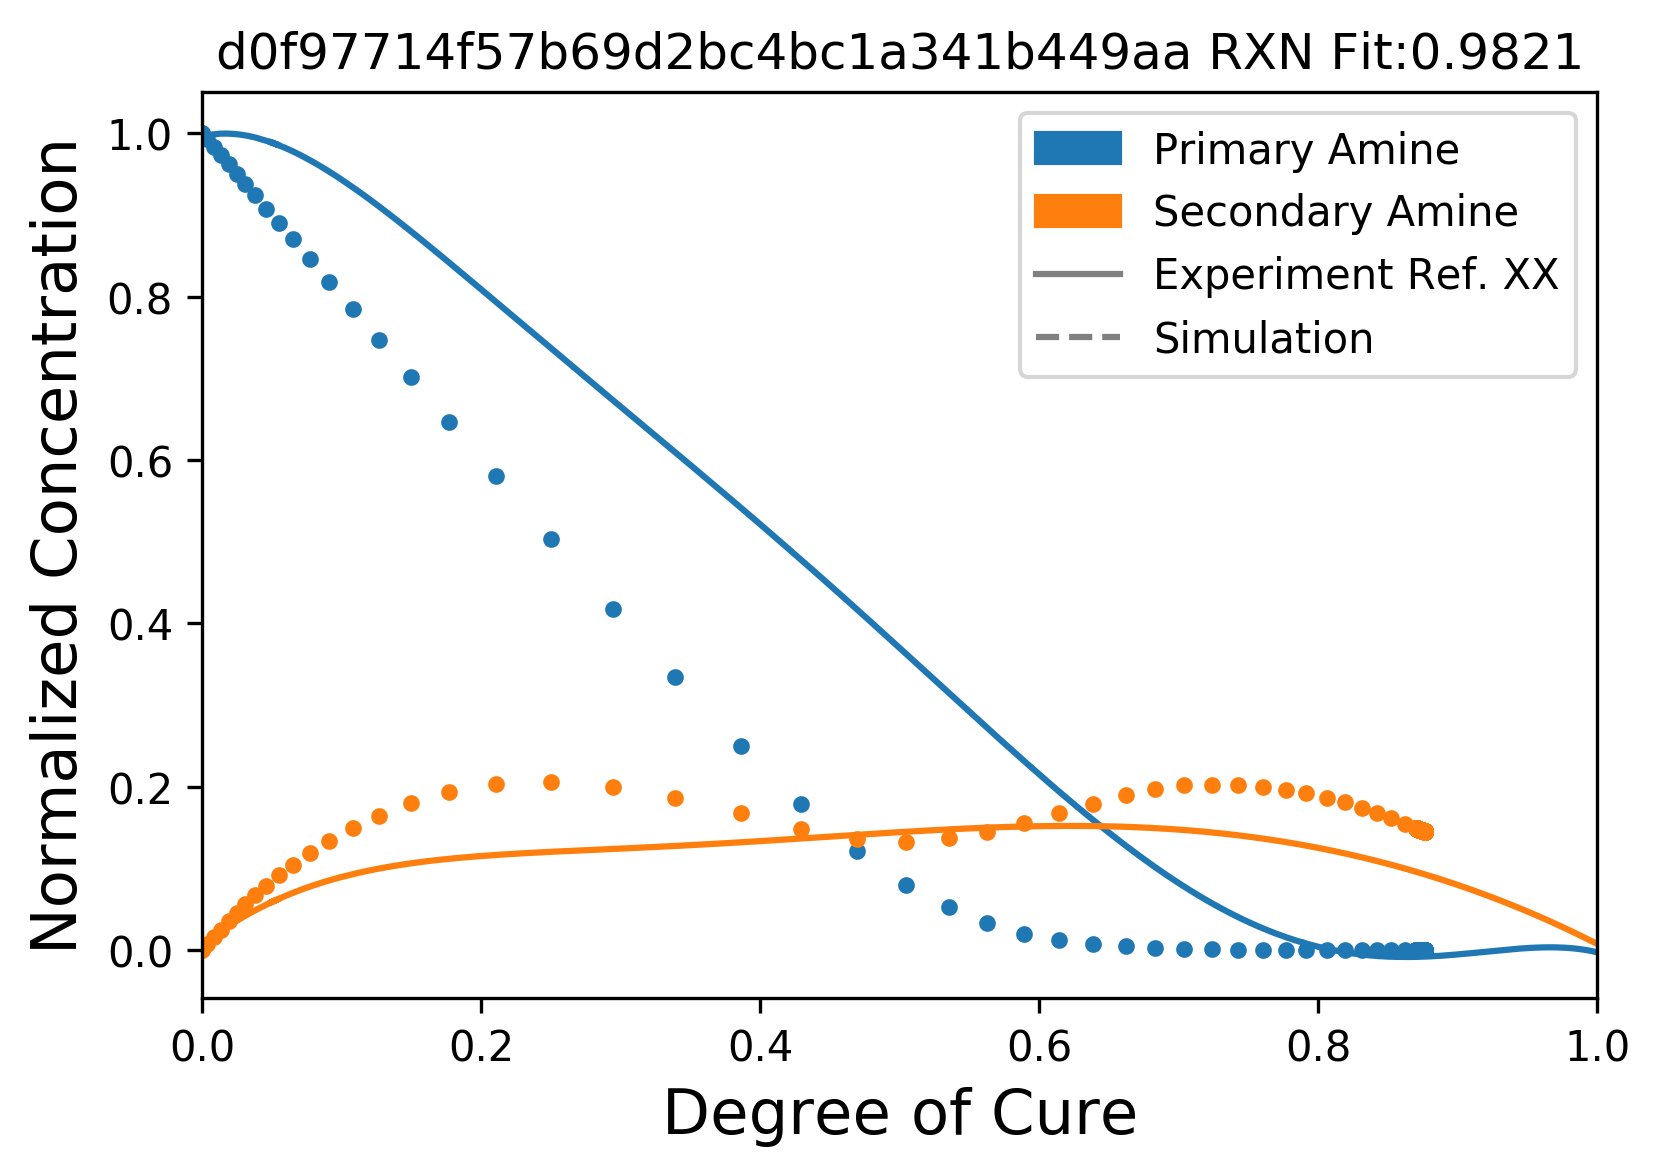

-----------
aab88e9c89c6a8c69ceb32e886c01ec7
R2 FO 0.9956465812006124
Ea 3.0
deltaT 5e-05
sec_bond_weight 1.8
% bonds per step 0.1
bond period 10
MSE Primary:  8.039327212273484e-05
MSE Secondary:  0.0014797442059309859
Mean MSE:  0.0008


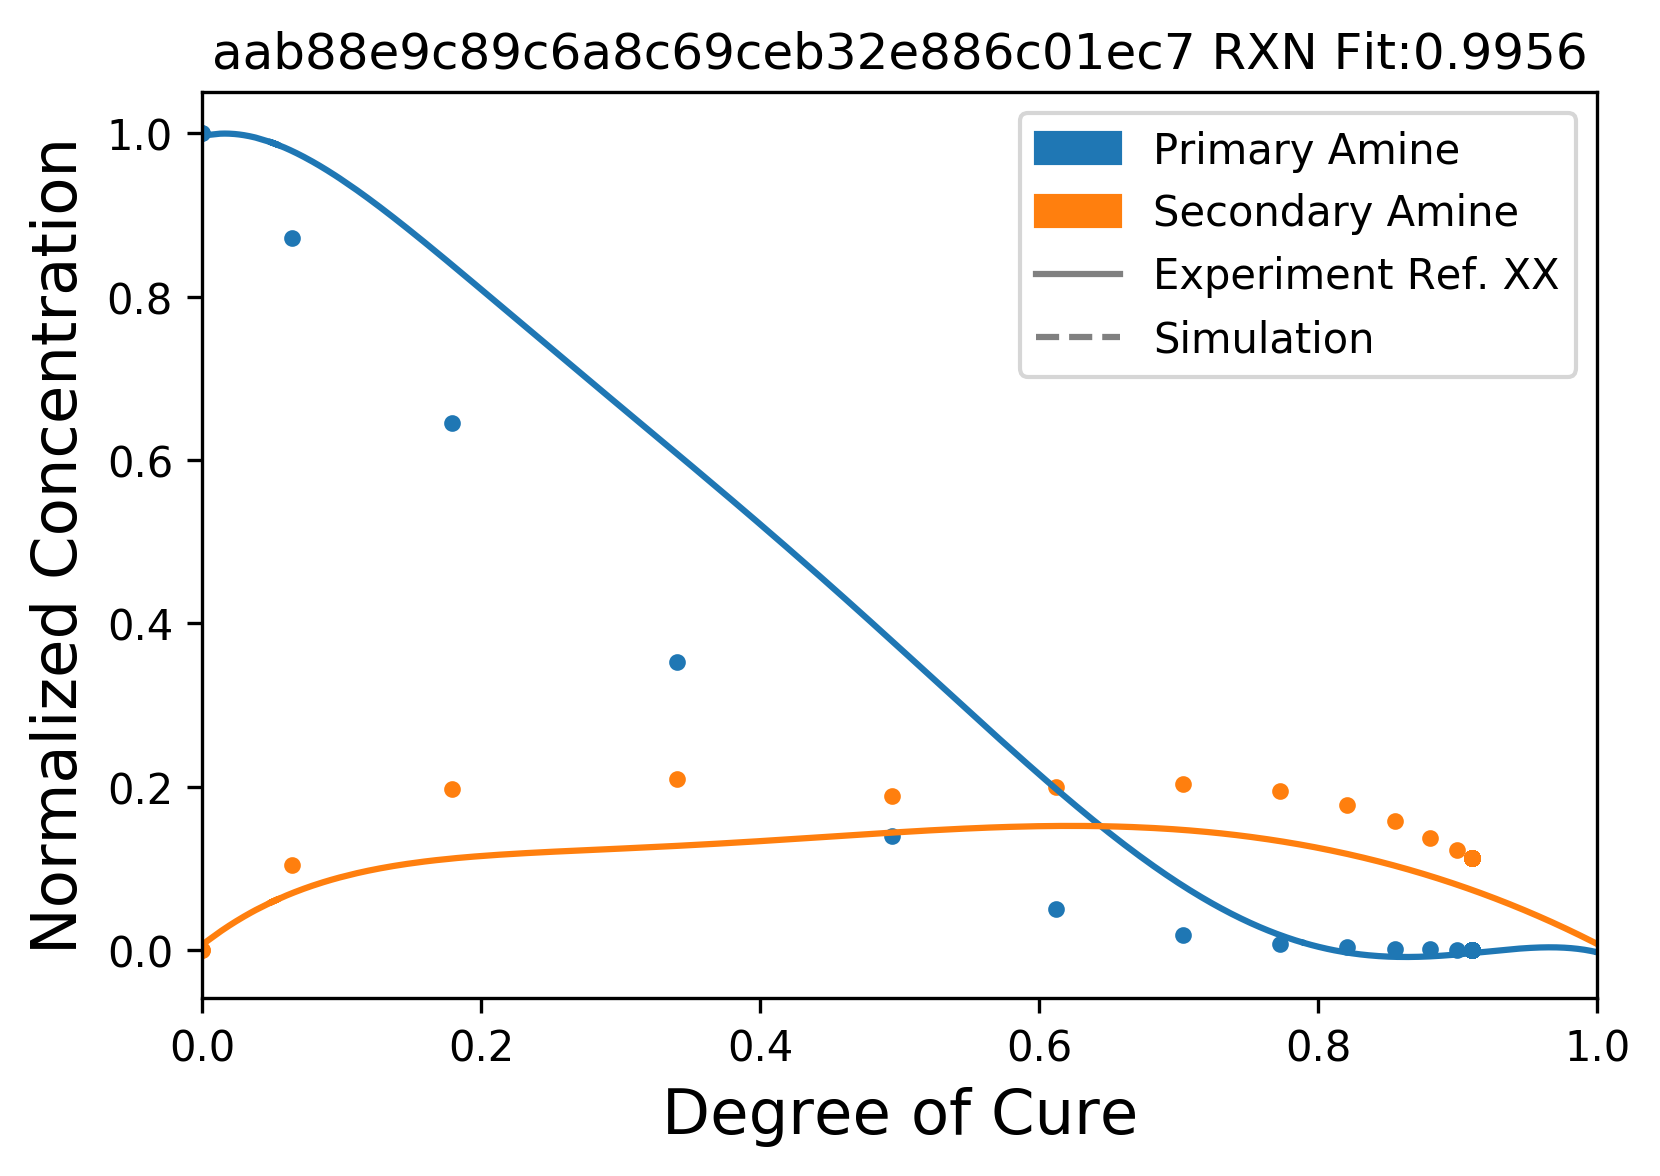

-----------
6d419f156c4492c96c0dbc3890ad0185
R2 FO 0.9855703863920975
Ea 5.5
deltaT 5e-05
sec_bond_weight 1.8
% bonds per step 1.0
bond period 100
MSE Primary:  0.0003871765335625709
MSE Secondary:  0.002275571496388141
Mean MSE:  0.0013


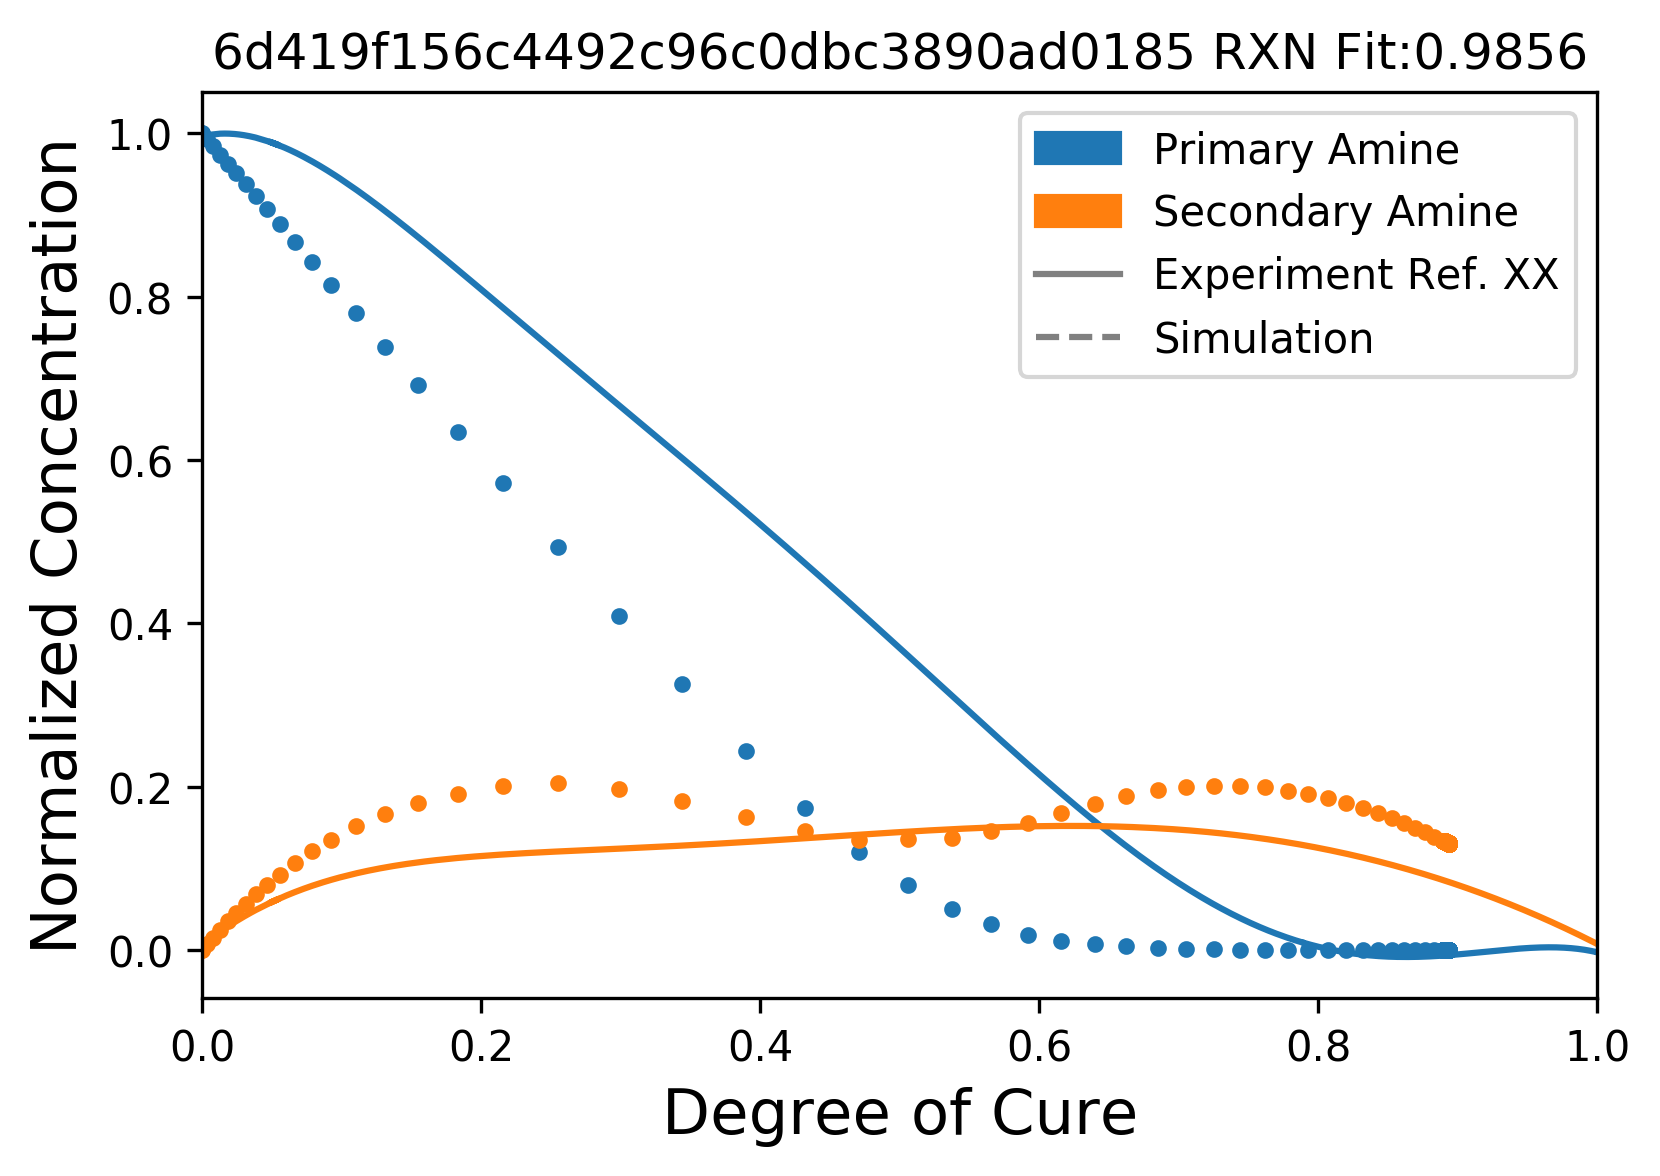

In [14]:
path = "/home/mikehenry/epoxy-stuff/rxn_tune_dgeba_big"

R2s, mean_MSEs = get_R2s_and_mean_MSEs(path)

plt.hist([_[0] for _ in R2s if _[0] > 0], bins=20)
plt.show()
plt.hist([_[0] for _ in mean_MSEs], bins=20)
plt.show()
top_ten = [_[1] for _ in sorted(R2s)[-20:]]
top_ten_MSE = [_[1] for _ in sorted(mean_MSEs, reverse=True)[-20:]]

top_ten = [_[1] for _ in R2s if _[0] > 0.98]

both = list(set(top_ten_MSE) & set(top_ten))
print(top_ten_MSE)
print(both)
make_plots(both, path)

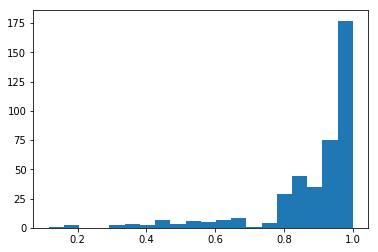

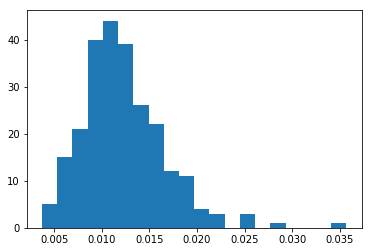

['b81ffc40adc2c6d6b9cdb4bfb40e2f34', '19da67dbadf904a9635438527b78a6fb', '261485d61e281b07adcbf091827cee66', '04e52906084f0063e83055ed4fc64567', 'd91141ca9ed955af183268f69292b2ff', '31094f943f6a1b24253860db70b23488', '27b5a252f63457e70c7f10a327683807', '2ad5505841becdc0236ffd9a722a2342', 'd0ceb63281049bb37a6757f127f24988', '1362213edac080d92349fe367375bb04', '2e166c53235058009bc0d47a652de00d', 'cc6a1d0fdace1ef7328445c5512fdbe2', 'e291e88ace342f4d20411ad17314ecb6', '26b701949151a77827469af62cc88519', '60170a2a4e5fd92f56f28a9da57dae42', '73f562eacefe9255322ec50a99c00ddd', '7ab34a85497fbae7236e35a90eba9200', '239fbce33615b884034f811695d9aceb', '3627df988a57eadd9e2f938c4f9b2c9b', 'b2b30a75d58391225509cda04984d709']
['261485d61e281b07adcbf091827cee66', '19da67dbadf904a9635438527b78a6fb', 'cc6a1d0fdace1ef7328445c5512fdbe2', '239fbce33615b884034f811695d9aceb', '27b5a252f63457e70c7f10a327683807', '73f562eacefe9255322ec50a99c00ddd']
-----------
19da67dbadf904a9635438527b78a6fb
R2 FO 0.998462104

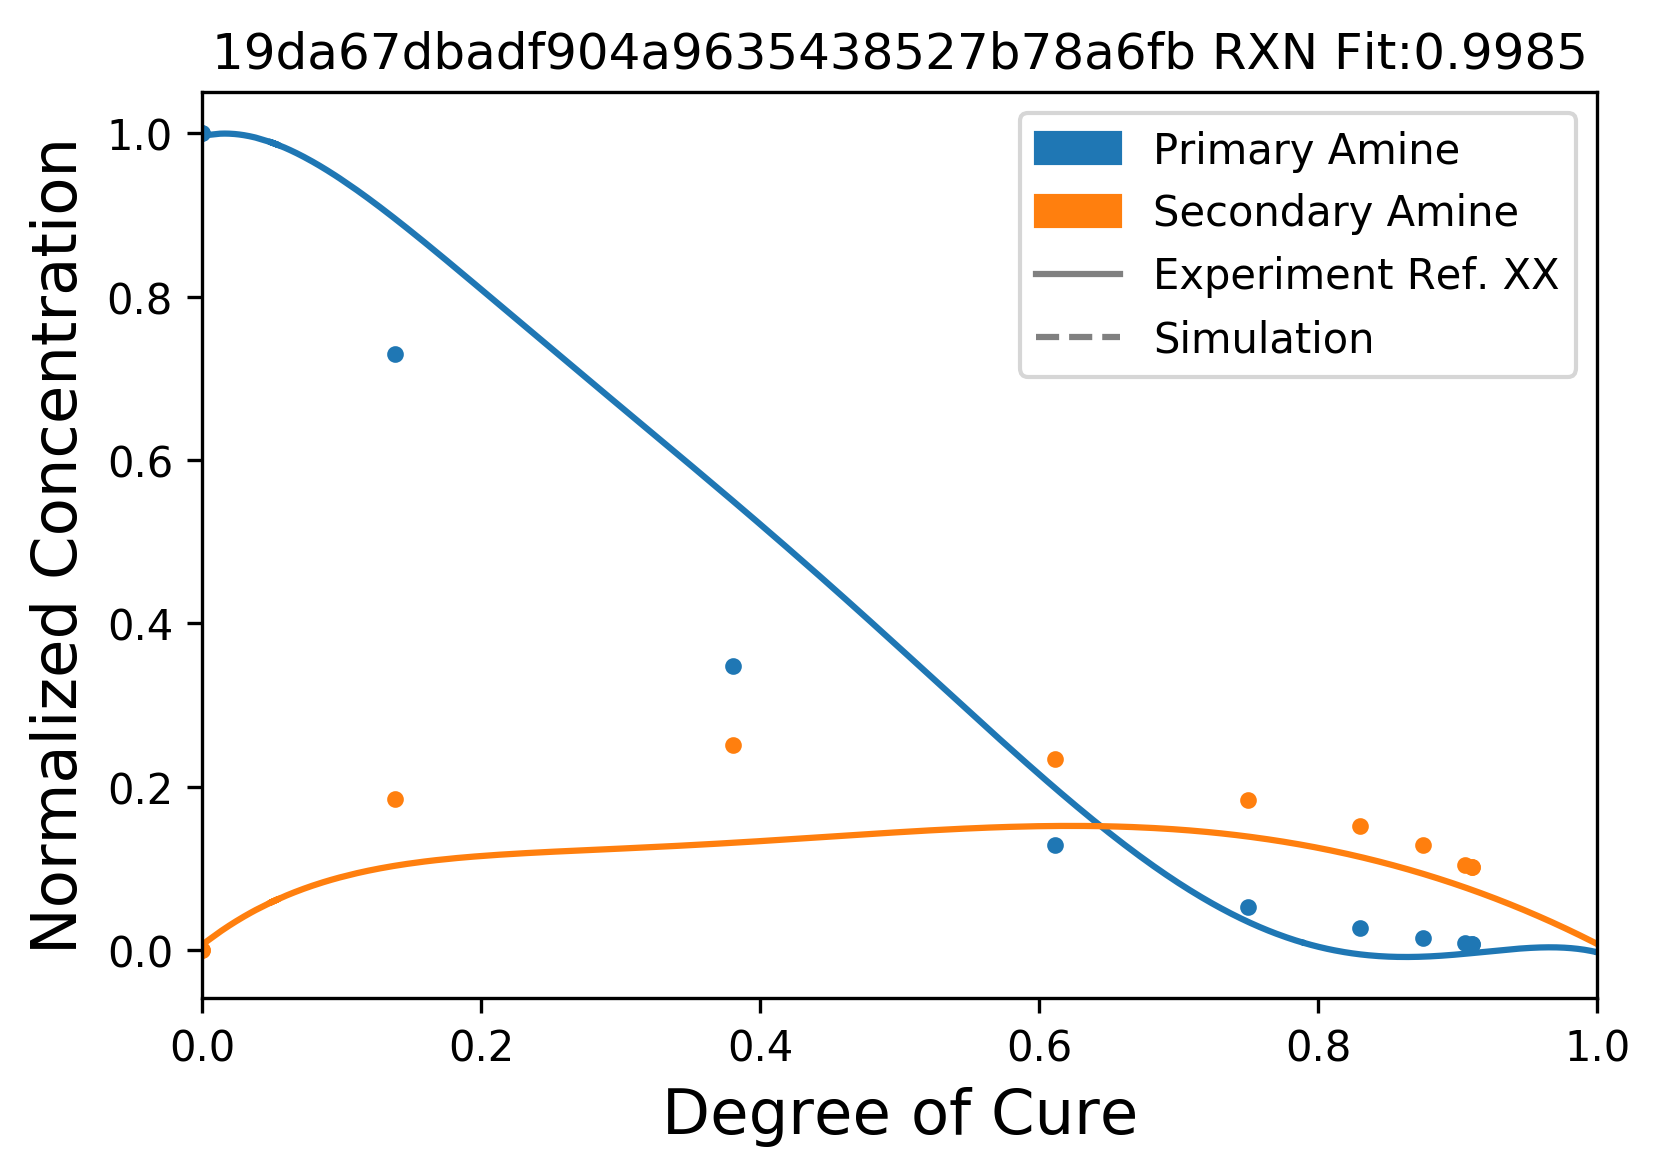

-----------
239fbce33615b884034f811695d9aceb
R2 FO 0.9886560004007364
Ea 5.5
deltaT 5e-05
sec_bond_weight 1.0
% bonds per step 0.1
bond period 1
MSE Primary:  0.004862936768113246
MSE Secondary:  0.0022450997527949683
Mean MSE:  0.0036


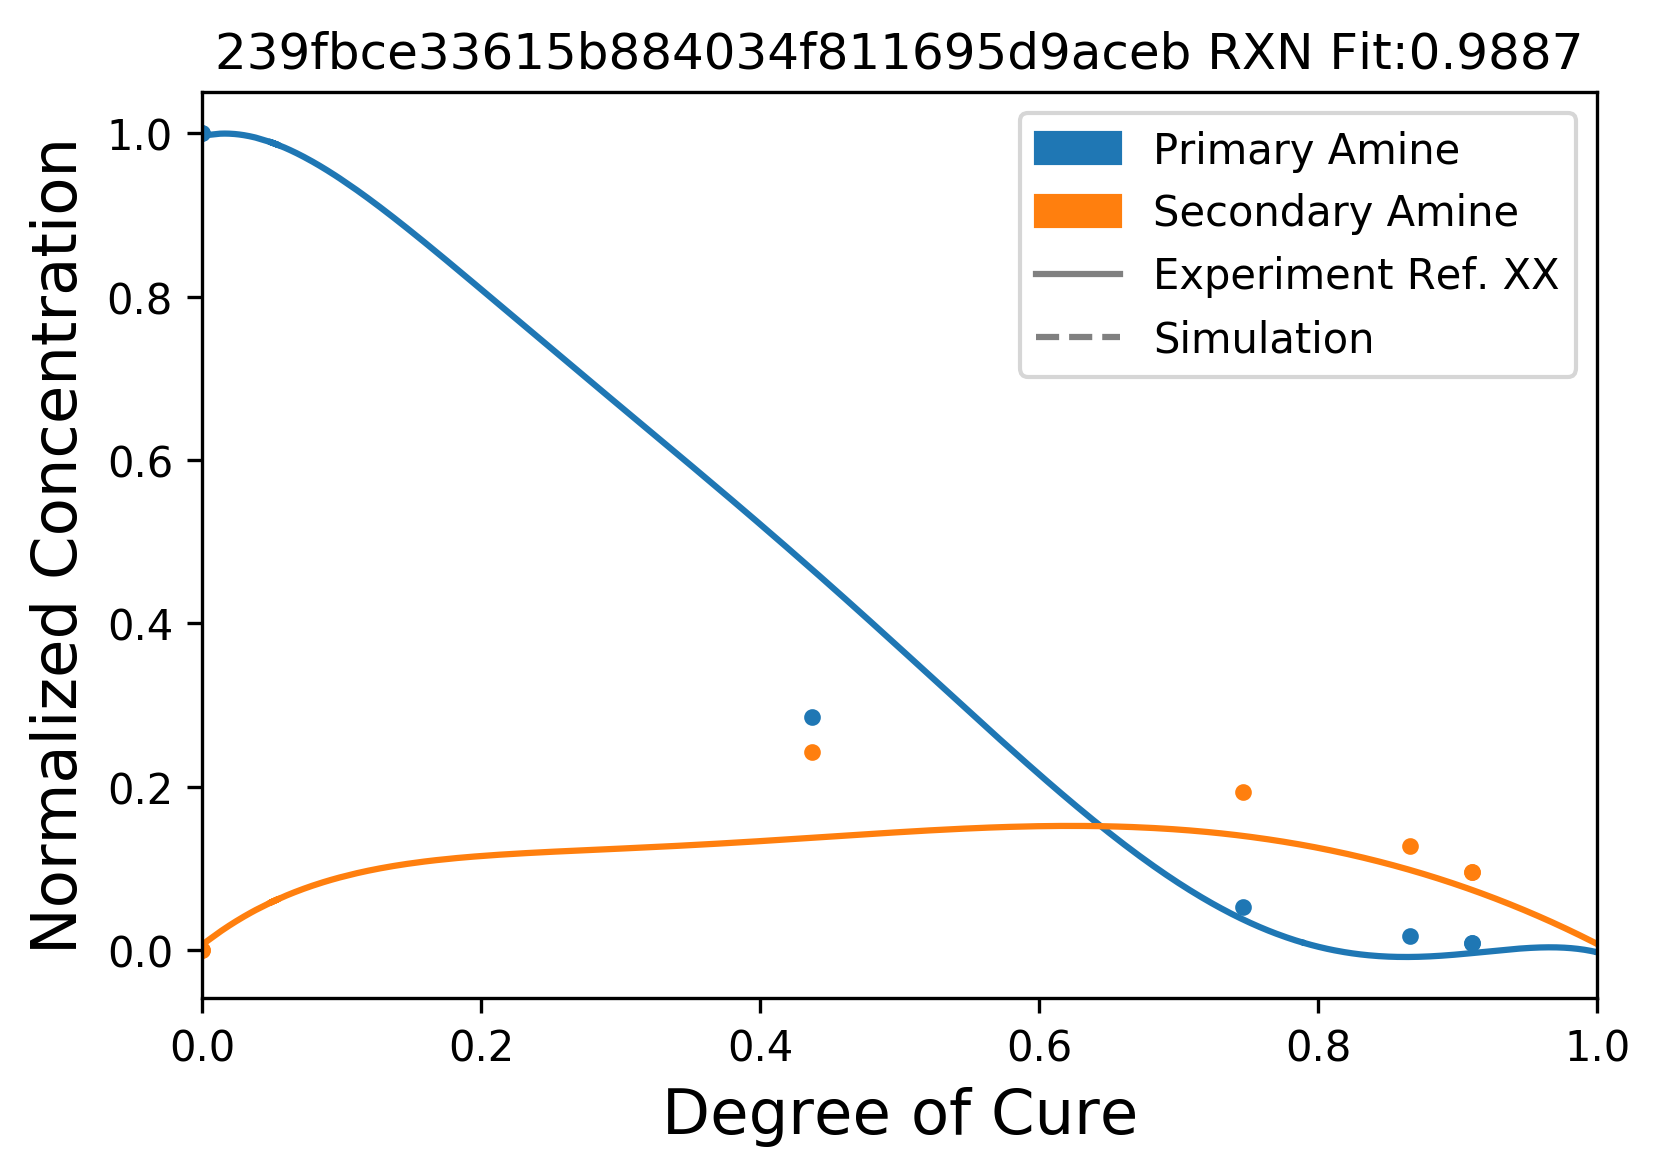

-----------
73f562eacefe9255322ec50a99c00ddd
R2 FO 0.9907780256872919
Ea 5.5
deltaT 5e-05
sec_bond_weight 1.0
% bonds per step 1.0
bond period 10
MSE Primary:  0.0052002578098437795
MSE Secondary:  0.0021612110960310413
Mean MSE:  0.0037


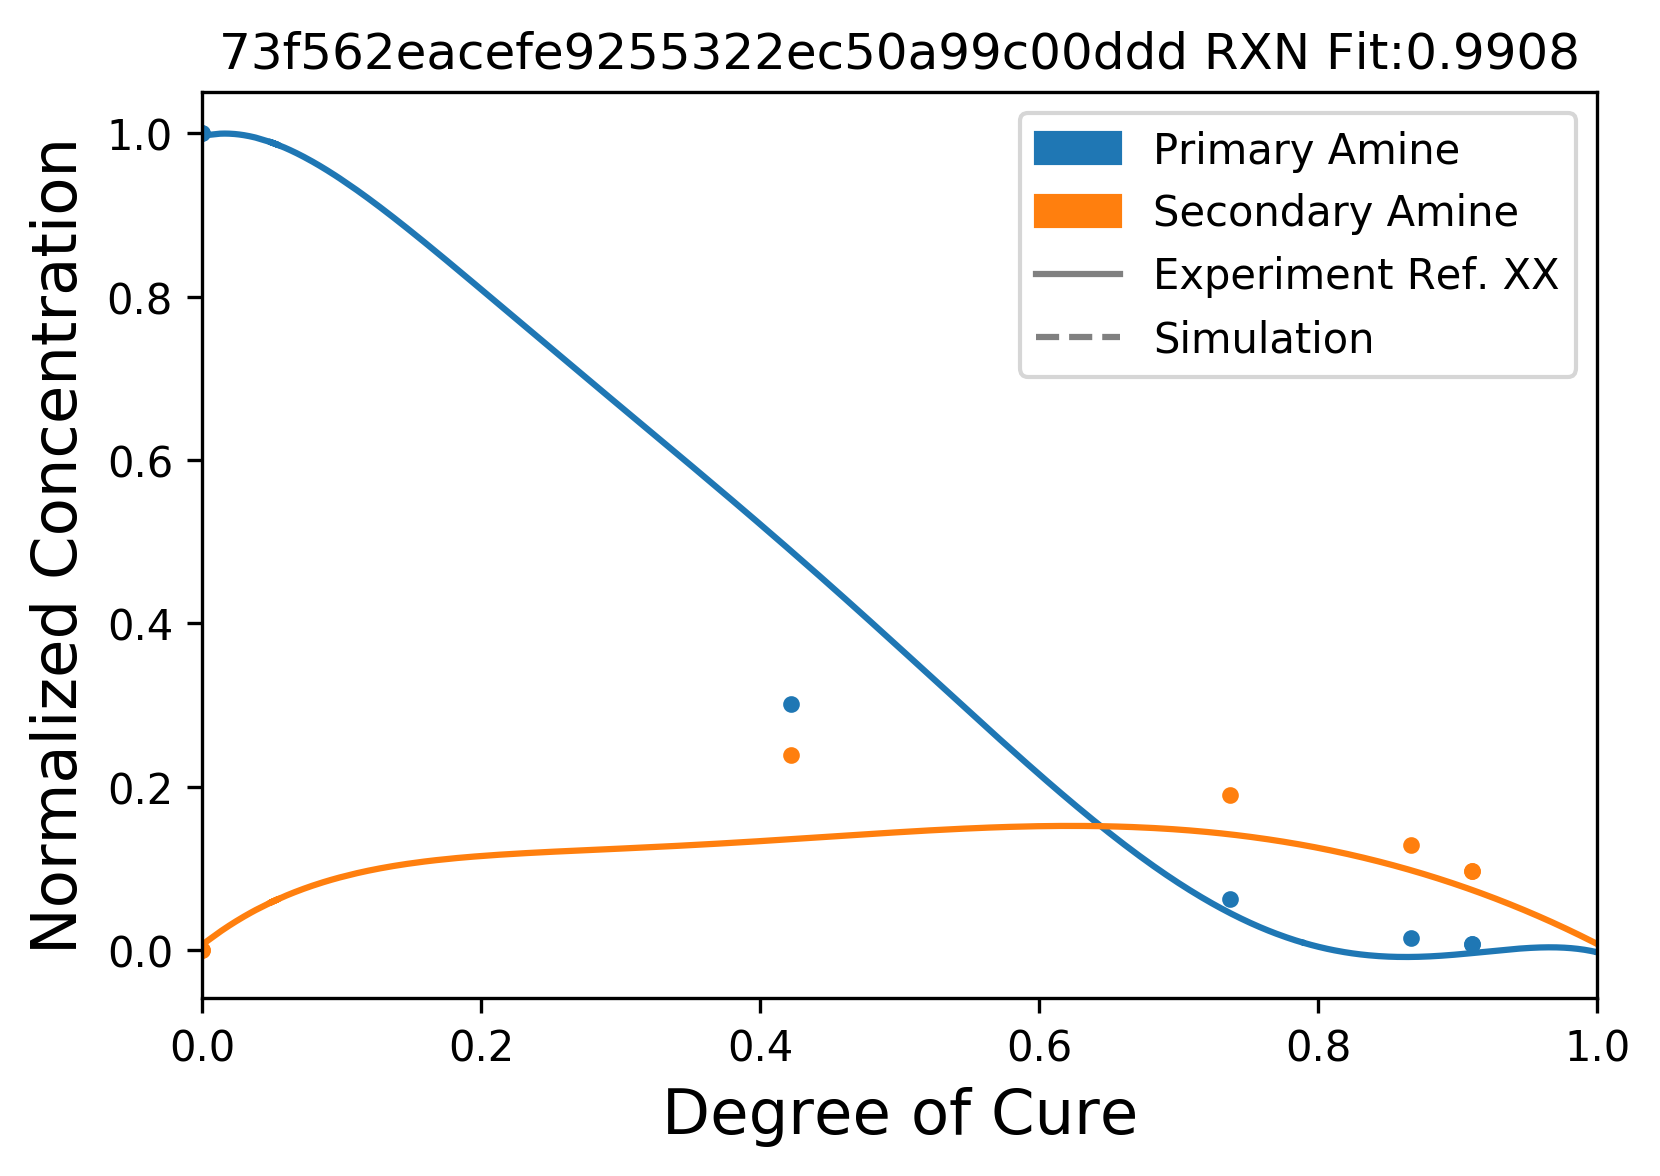

-----------
cc6a1d0fdace1ef7328445c5512fdbe2
R2 FO 0.991595301985509
Ea 3.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 0.01
bond period 1
MSE Primary:  0.00595024207462824
MSE Secondary:  0.002758647895595666
Mean MSE:  0.0044


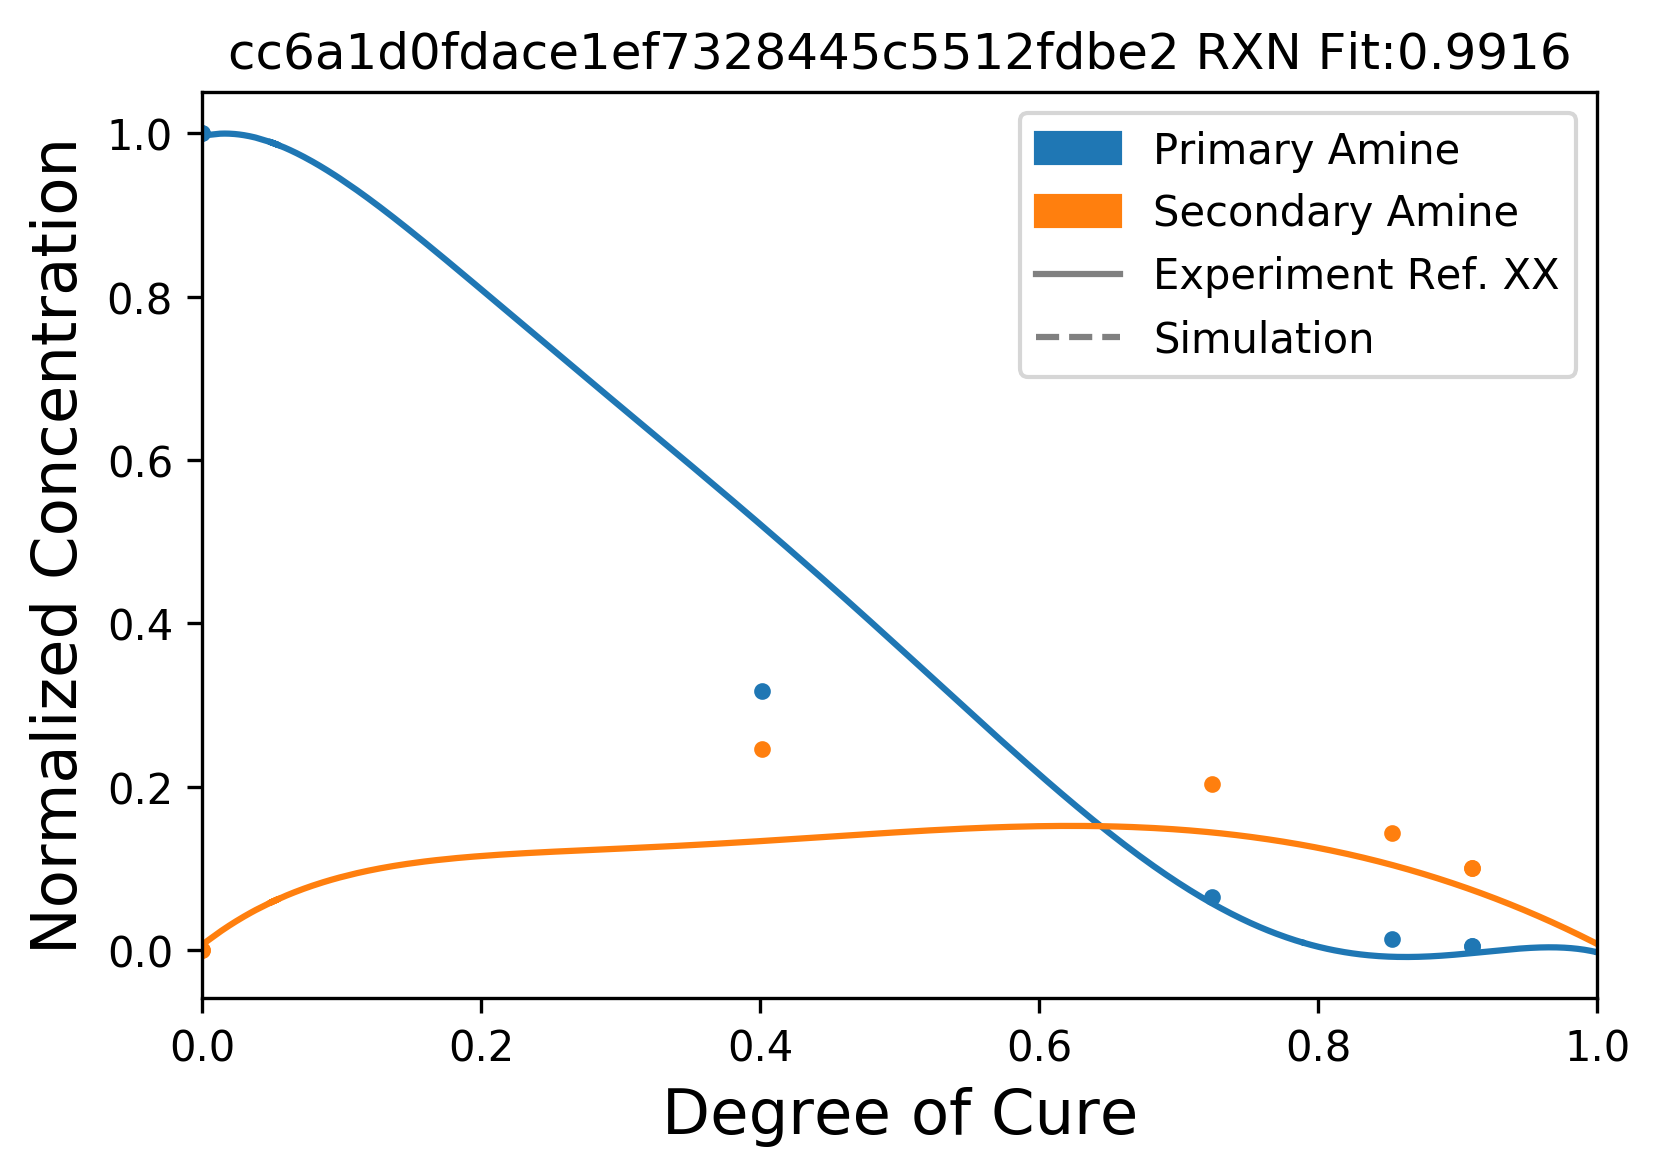

-----------
27b5a252f63457e70c7f10a327683807
R2 FO 0.9904191791566788
Ea 6.0
deltaT 5e-05
sec_bond_weight 1.0
% bonds per step 1.0
bond period 10
MSE Primary:  0.0066006689723823175
MSE Secondary:  0.0030072747014858905
Mean MSE:  0.0048


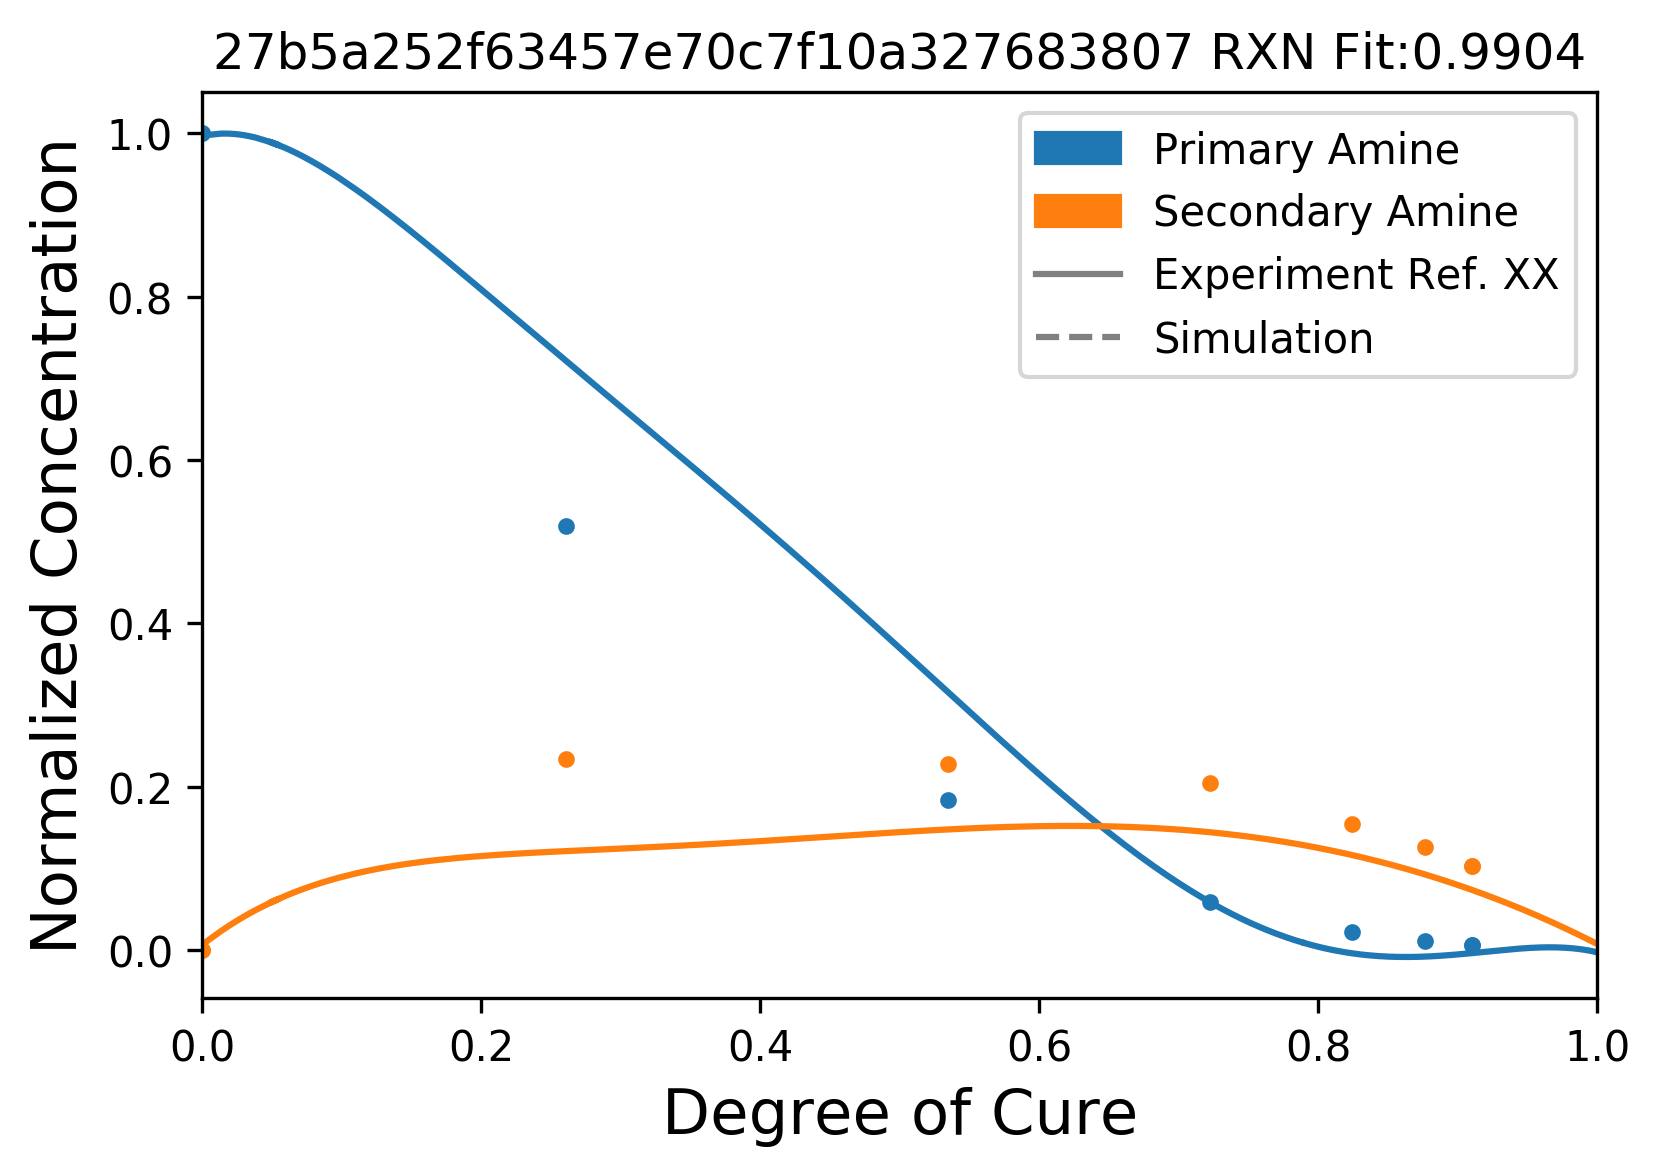

-----------
261485d61e281b07adcbf091827cee66
R2 FO 0.9959874686680817
Ea 6.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 0.1
bond period 1
MSE Primary:  0.006888433157246229
MSE Secondary:  0.002443500831500364
Mean MSE:  0.0047


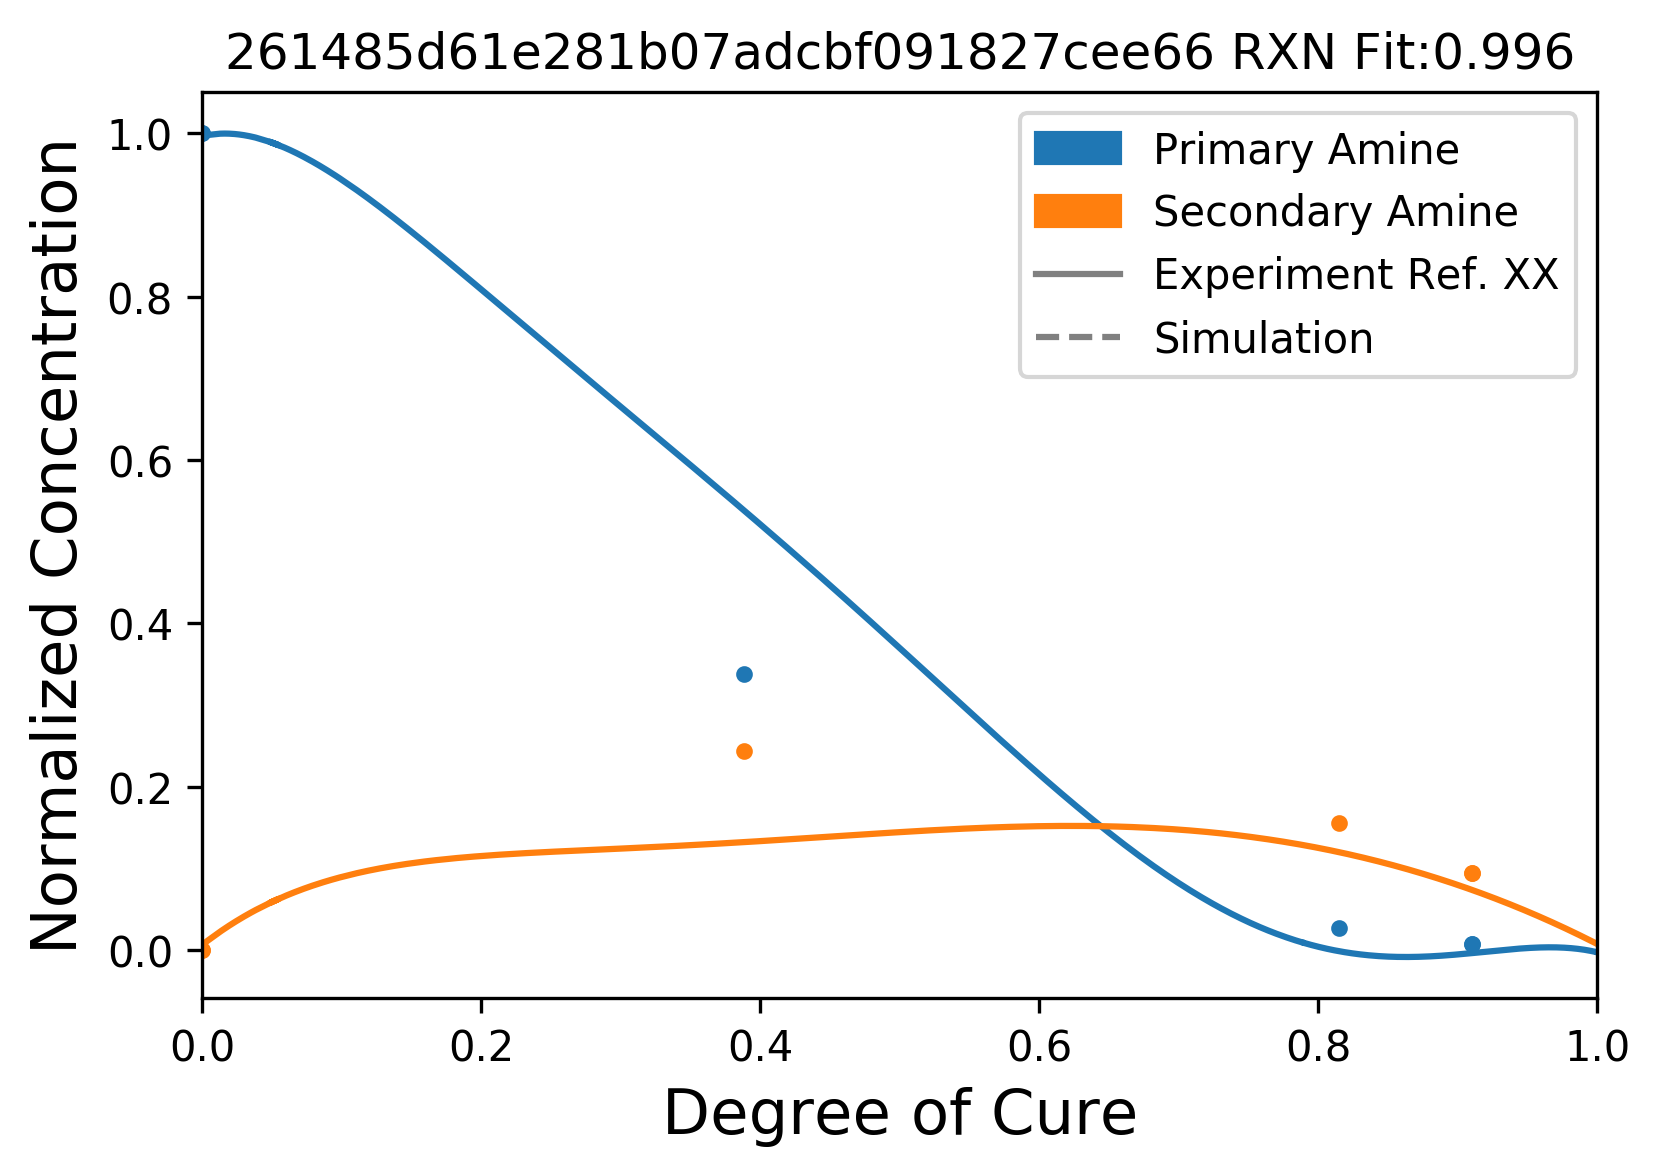

In [4]:
path = "/home/mikehenry/epoxy-stuff/rxn_tune_dgeba"

R2s, mean_MSEs = get_R2s_and_mean_MSEs(path)

plt.hist([_[0] for _ in R2s if _[0] > 0], bins=20)
plt.show()
plt.hist([_[0] for _ in mean_MSEs], bins=20)
plt.show()
#top_ten = [_[1] for _ in sorted(R2s)[-20:]]
top_ten_MSE = [_[1] for _ in sorted(mean_MSEs, reverse=True)[-20:]]


top_ten = [_[1] for _ in R2s if _[0] > 0.98]
#top_ten_MSE = [_[1] for _ in mean_MSEs if _[0] < 0.005]



both = list(set(top_ten_MSE) & set(top_ten))
print(top_ten_MSE)
print(both)
make_plots(both, path)